In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb 
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score,recall_score
from sklearn.feature_selection import SelectKBest,SelectPercentile,SelectFromModel,chi2,f_classif,mutual_info_classif,RFE
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVC,LinearSVC,LinearSVR,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import gc
import pickle
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.


In [2]:
start_date = '2005-05-01'
end_date = '2018-05-31'

test_start_date = '2018-06-01'
test_end_date = '2020-01-28'
start_year = start_date[:4]
end_year = end_date[:4]

select_index = '000300.XSHG'
next_n = 3 #data_y延期n月

start_quarter = '2015-05'
start_month = '2015-05'

seq_len = 6 #lstm back num

In [3]:
res =  pd.read_csv("data/沪深300月度宏观经济数据1.csv",header=0,index_col=0,sep='\s+',parse_dates=[1])
res_a = pd.read_csv("data/沪深300月度宏观经济数据2.csv",header=0,index_col=0,sep='\s+',parse_dates=[1])
price = pd.read_csv("data/沪深300每日交易close价格.csv",header=0,index_col=0,sep='\s+',parse_dates=[0])

In [4]:
res.index = res['stat_month']
res_a.index = res_a['stat_month']

In [5]:
def get_macro_data(ml,sd, ed):
    res_ = res.loc[ml[0]:ml[-1]]
    res_a_ = res_a.loc[ml[0]:ml[-1]]
    price_ = price.loc[sd:ed]
    return [res_, res_a_, price_]

In [6]:
def get_year_list(start_year,end_year):
    sy = int(start_year)
    ey = int(end_year)
    l = []
    for i in range(sy,ey+1):
        l.append(str(i))
    return l

In [7]:
def get_quarter_list(start_year,end_year):
    sy = int(start_year)
    ey = int(end_year)
    l = []
    for y in range(sy,ey+1):
        for q in range(3,13,3):
            if q < 10:
                s = str(y) + '-' + '0' + str(q)
                l.append(s)
            else:
                s = str(y) + '-' +  str(q)
                l.append(s)
    return l

In [8]:
def get_month_list(start_date,end_date):
    sy = int(start_date[:4])
    ey = int(end_date[:4])
    sm = int(start_date[5:7])
    em = int(end_date[5:7])
    l = []
    for y in range(sy,ey+1):
        if y == sy:
            for i in range(sm,13):
                if i< 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' +  str(i)      
                    l.append(s)
               
        elif y == ey:
            for i in range(1,em+1):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' +  str(i)
                    l.append(s)
        else:           
            for i in range(1,13):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' +  str(i)
                    l.append(s)
    return l

In [9]:
#获取月度价格数据
def get_price_month_data(price_day,n='mean',mean_num=1):
    '''
    :param price: 输入价格数据，index为datetime类型
    :param type: 计算方式，’mean‘取月平均值，若为int,则从第几个交易日开始计算均值，长度为mean_num，
    :param mean_num: 计算均值的长度
    :return:
    '''
    ind = list(price_day.index)
    s_ind = [datetime.datetime.strftime(i, '%Y%m%d') for i in ind]
    price_day.index = s_ind
    num_ind = [int(i) for i in s_ind]
    cut_ind = [int(i / 100) for i in num_ind]
    cut_s_ind = [(str(i)[:4] + '-' + str(i)[4:]) for i in cut_ind]
    price_day['stat_date'] = cut_s_ind
    if n == 'mean':
        res = price_day.groupby(by=['stat_date']).mean()
    else:
        ind_sig = list(set(price['stat_date'].values))
        index_list = []
        mean_list = []
        for ind in ind_sig:
            df = price[price['stat_date']==ind]
            sel_df = df.iloc[n-1:n+mean_num-1,0]
            index = list(sel_df.index)
            if len(index) == 0:
                continue
            index = index[0]
            index_list.append(index)
            mean_df = sel_df.mean()
            mean_list.append(mean_df)
        res_df = pd.DataFrame(mean_list,index=index_list,columns=['month_price'])
        res = res_df.sort_index()
        res_index = list(res.index)
        ind_s_cut = [i[:4] + '-' + i[4:6] for i in res_index]
        res.index = ind_s_cut
    return res

In [10]:
def get_pure_values(data):
    '''
    获取纯净数值，将DataFrame中的非数值项剔除，例如‘code’项（str）
    input:
    data:pd.DataFrame,index为股票代码
    putput:
    DataFrame：只含数值项
    '''
    columns = list(data.columns)
    for column in columns:
        if not(isinstance(data[column][0],int) or isinstance(data[column][0],float)):
            data = data.drop([column],axis=1)
    return data

In [11]:
def winsorize_and_standarlize(data, qrange=[0.05, 0.95], axis=0):
    if isinstance(data, pd.DataFrame):
        if axis == 0:
            q_down = data.quantile(qrange[0])
            q_up = data.quantile(qrange[1])
            col = data.columns
            for n in col:
                data[n][data[n] > q_up[n]] = q_up[n]
                data[n][data[n] < q_down[n]] = q_down[n]
            data = (data - data.mean()) / data.std()
            data = data.fillna(0)
        else:
            data = data.stack()
            data = data.unstack(0)
            q_down = data.quantile(qrange[0])
            q_up = data.quantile(qrange[1])
            col = data.columns
            for n in col:
                data[n][data[n] > q_up[n]] = q_up[n]
                data[n][data[n] < q_down[n]] = q_down[n]
            data = (data - data.mean()) / data.std()
            data = data.stack().unstack(0)
            data = data.fillna(0)

    elif isinstance(data, pd.Series):
        q_down = data.quantile(qrange[0])
        q_up = data.quantile(qrange[1])
        data[data > q_up] = q_up
        data[data < q_down] = q_down
        data = (data - data.mean()) / data.std()
    return data

In [12]:
def get_profit_class(data):
    '''
    对数据进行分类标记
    '''
    data_diff = data.diff(next_n)
    data_diff[data_diff > 0] = 1
    data_diff[data_diff < 0] = 0
    #data_diff[data_diff == 2] = -1
    #data_diff[data_diff == -2] = 1
    return data_diff

def get_final_data(input_x,input_y):
    input_y = input_y.shift(-next_n).to_frame().fillna(method='ffill')
    data_m = pd.merge(input_x,input_y,left_index=True,right_index=True,how='right')
    columns_m = data_m.columns
    data_x = data_m[columns_m[:-1]]
    data_y = data_m[columns_m[-1]]
    return data_x,data_y

In [13]:
class FeatureSelection():
    '''
    特征选择：
    identify_collinear：基于相关系数，删除小于correlation_threshold的特征
    identify_importance_lgbm：基于LightGBM算法，得到feature_importance,选择和大于p_importance的特征
    filter_select:单变量选择，指定k,selectKBest基于method提供的算法选择前k个特征，selectPercentile选择前p百分百的特征
    wrapper_select:RFE，基于estimator递归特征消除，保留n_feature_to_select个特征
    '''
    def __init__(self):
        self.filter_supports = None #bool型，特征是否被选中
        self.wrapper_supports = None
        self.embedded_supports = None
        self.lgbm_columns = None  #选择的特征
        self.filter_columns = None
        self.wrapper_columns = None
        self.embedded_columns = None
        self.record_collinear = None #自相关矩阵大于门限值
        
    def identify_collinear(self, data, correlation_threshold):

        columns = data.columns
        self.correlation_threshold = correlation_threshold

        # Calculate the correlations between every column
        corr_matrix = data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]
        obtain_columns = [column for column in columns if column not in to_drop]
        self.columns = obtain_columns
        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        return data[obtain_columns]
     
        
    def identify_importance_lgbm(self, features, labels,p_importance=0.8, eval_metric='auc', task='classification', 
                                 n_iterations=10, early_stopping = True):
        
        # One hot encoding
        data = features
        features = pd.get_dummies(features)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        #print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=100, learning_rate = 0.05, verbose = 1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=100, learning_rate = 0.05, verbose = 1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                           verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
        select_df = feature_importances[feature_importances['cumulative_importance']<=p_importance]
        select_columns = select_df['feature']
        self.lgbm_columns = list(select_columns.values)
        res = data[self.columns]
        return res
        
    def filter_select(self, data_x, data_y, k=None, p=50,method=f_classif):
        columns = data_x.columns
        if k != None:
            model = SelectKBest(method,k)
            res = model.fit_transform(data_x,data_y)
            supports = model.get_support()
        else:
            model = SelectPercentile(method,p)
            res = model.fit_transform(data_x,data_y)
            supports = model.get_support()
        self.filter_support_ = supports
        self.filter_columns = columns[supports]
        return res
    
    def wrapper_select(self,data_x,data_y,n,estimator):
        columns = data_x.columns
        model = RFE(estimator=estimator,n_features_to_select=n)
        res = model.fit_transform(data_x,data_y)
        supports = model.get_support() #标识被选择的特征在原数据中的位置
        self.wrapper_supports = supports
        self.wrapper_columns = columns[supports]
        return res
    
    def embedded_select(self,data_x,data_y,estimator,threshold=None):
        columns = data_x.columns
        model = SelectFromModel(estimator=estimator,prefit=False,threshold=threshold)
        res = model.fit_transform(data_x,data_y)
        supports = model.get_support()
        self.embedded_supports = supports
        self.embedded_columns = columns[supports]
        print("self.embedded_columns:",self.embedded_columns)
        return res


In [14]:
#调参时计算召回率和准确率
def lstm_recall(prediction,y,n=1,thr=0.5):
    len_p = len(prediction)
    l = 0
    z = 0
    res = []
    if n == 1:
        for i in range(len_p):
            if (prediction[i]>= thr):
                l = l+1
                if (y[i] ==1):
                    z = z+1
    elif n==0:
         for i in range(len_p):
            if (prediction[i]<=thr):
                l = l+1
                if (y[i] ==0):
                    z = z+1
    lstm_recall = z/l
    return lstm_recall

def lstm_accuracy(prediction,y,thr=0.5):
    len_p = len(prediction)
    l = 0
    for i in range(len_p):
        if ((prediction[i]>=thr) & (y[i] ==1)) |  ((prediction[i]<thr) & (y[i] ==0)):
            l = l + 1
            
    accuracy = l/len_p
    return accuracy

In [15]:
def res_output(res,buy_thr=1.6,sell_thr=1.0):
    '''
    基于lgbm和embedded两组特征选择数据的计算结果确定预测结果
    buy_thr:预测股价上升的门限值，默认1.5,
    sell_thr:预测股价下降的门限值，默认0.5
    大于买入门限标记为1，小于卖出门限标记为-1，中间值认为买入卖出信号不强，选择观望或空仓，卖出信号可用于做空，在无法做空时认为空仓
    
    '''
    length = len(res)
    l = []
    for i in range(length):
        if res[i] > buy_thr:
            l.append(1)
        elif res[i] < sell_thr:
            l.append(-1)
        else:
            l.append(0)
    return l


In [16]:
def LSTM_fun_keras(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())
    INPUT_DIM = n_input
    output_dim = 1
    batch_size = 8 #每轮训练模型时，样本的数量
    epochs = 100 #训练60轮次
    hidden_size = 64
    lstm_units = 32
    inputs = Input(shape=(seq_len, INPUT_DIM))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = seq_len)(x)
    x = Dropout(0.1)(x)
    #print(x.shape)
    lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    #print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    #h1 = Dense(hidden_size, activation='relu')(attention_mul)
    output_class = Dense(1, activation='sigmoid')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model_class = Model(inputs=inputs, outputs=output_class)
    #print(model_class.summary())
    #model_class.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    # fit model
    history_class = model_class.fit(train_x, train_y,validation_split=0.2, epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=[es])
    y_pred_class = model_class.predict(predict_x)
    print("accuracy:",lstm_accuracy(y_pred_class,prediction_y,thr=0.5))
    return y_pred_class

In [42]:
def LSTM_fun(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    #LSTM
    lr=0.1
    lstm_size = 3  #lstm cell数量，基于数据量调整
    epoch_num = 10  #打印次数，和n_batch相乘便是迭代次数
    n_batch = 200
    lookback = seq_len
    tf.reset_default_graph()


    x = tf.placeholder(tf.float32,[None,lookback,n_input])
    y = tf.placeholder(tf.float32,[None,1])

    weights = tf.Variable(tf.truncated_normal([lstm_size,1],stddev=0.1))
    biases = tf.Variable(tf.constant(0.1,shape=[1]))

    def LSTM_net(x,weights,biases):
        lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size,name='basic_lstm_cell') #.BasicLSTMCell(lstm_size)
        output,final_state = tf.nn.dynamic_rnn(lstm_cell,x,dtype=tf.float32)
        results = tf.nn.sigmoid(tf.matmul(final_state[1],weights)+biases)
        return results

    prediction = LSTM_net(x,weights,biases)

    loss = tf.reduce_mean(tf.square(y - prediction))

    train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for i in range(epoch_num):
            for j in range(n_batch):
                sess.run(train_step,feed_dict={x:train_x,y:train_y})
                train_loss = sess.run(loss,feed_dict={x:train_x,y:train_y})
            print('train loss is'+ str(train_loss))
        prediction_res = sess.run(prediction,feed_dict={x:predict_x})
    print("accuracy:",lstm_accuracy(prediction_res,prediction_y,thr=0.5))
    return prediction_res


In [43]:
def get_test_time_list(start_date,test_start_date,test_end_date):
    '''
    使用机器学习算法计算时的时间数据
    input:
    start_date:取宏观数据的开始时间
    test_start_date:预测的开始时间，也就是取宏观数据的截止时间
    test_end_date:预测的截止时间，对期间的每一个月都要预测，每一个月都要重跑一遍预测函数，每个月的开始使用上个月28号的价格数据作为截止价格时间
    output:
    m_l：每一次预测时的月份列表，在此列表内跑预测函数，
    start_date,取宏观数据和价格数据的开始时间，由全局变量定义
    ed:取价格数据截止时间列表，顺序和m_l对应
    '''
    test_month = get_month_list(test_start_date,test_end_date)
    m_l_pre = []
    ed = []
    for m in test_month:
        ml = get_month_list(start_date,m)
        m_l_pre.append(ml)
        if m == test_month[-1]:
            ed.append(test_end_date)
        else:
            ed.append(m+'-'+'28')
    return m_l_pre,start_date,ed

In [44]:
ml_test,sd_test,ed_test = get_test_time_list(start_date,test_start_date,test_end_date)

In [65]:
def monthly_fun(month_list, start_date, end_date):
    macro_data_o = get_macro_data(month_list,start_date, end_date)
    res = macro_data_o[0]
    res_a = macro_data_o[1]
    price = macro_data_o[2]
    price_month = get_price_month_data(price)
    res.index = res['stat_month']
    res_a.index = res['stat_month']

    sel_data = pd.merge(res_a, price_month, left_index=True, right_index=True).dropna()  # 使用全部宏观数据
    data_pure = get_pure_values(sel_data)
    columns = data_pure.columns
    data_x_start = data_pure[columns[:-1]]
    data_y_o = data_pure[columns[-1]]
    data_x_o = winsorize_and_standarlize(data_x_start)
    data_y_class_o = get_profit_class(data_y_o)
    data_x, data_y_class = get_final_data(data_x_o, data_y_class_o)
    _, data_y = get_final_data(data_x_o, data_y_o)
    # 特征选择
    #print("特征选择")
    f = FeatureSelection()
    #print("去除一些共线性特征")
    n_collinear = f.identify_collinear(data_x, correlation_threshold=0.8) #去除一些共线性特征
    #print("lightgbm 重要特征")
    lgbm_res = f.identify_importance_lgbm(n_collinear, data_y_class, p_importance=0.9)

    #estimator = LinearSVC()
    #wrapper_res = f.wrapper_select(data_x=n_collinear, data_y=data_y_class, n=5, estimator=estimator)

    #est = LinearSVC(C=0.01, penalty='l1', dual=False)
    #print("random forest 重要特征")
    est1 = RandomForestClassifier(verbose=1)
    embedded_res = f.embedded_select(data_x=n_collinear, data_y=data_y_class, estimator=est1)
    # LSTM数据准备
    #print("数据准备")
    lgbm_n_input = len(lgbm_res.columns)
    print("lgbm_res.columns:",lgbm_res.columns)
    lgbm_x_a = np.array(lgbm_res)
    lgbm_x_o = [lgbm_x_a[i: i + seq_len, :] for i in range(lgbm_res.shape[0] - seq_len)]
    lgbm_x_l = len(lgbm_x_o)
    lgbm_x_array = np.reshape(lgbm_x_o, [lgbm_x_l, seq_len, lgbm_n_input])
    lgbm_x = lgbm_x_array[:-next_n]
    lgbm_x_prediction = lgbm_x_array[-next_n:]
    lgbm_y_o = np.array([data_y_class[i + seq_len] for i in range(len(data_y_class) - seq_len)])
    lgbm_y_array = np.reshape(lgbm_y_o, [lgbm_y_o.shape[0], 1])
    lgbm_y = lgbm_y_array[:-next_n]
    lgbm_y_prediction = lgbm_y_array[-next_n:]
    # print(len(lgbm_y))

    embedded_n_input = np.shape(embedded_res)[1]
    embedded_x_a = np.array(embedded_res)
    embedded_x_o = [embedded_x_a[i: i + seq_len, :] for i in range(embedded_res.shape[0] - seq_len)]
    embedded_x_l = len(embedded_x_o)
    embedded_x_array = np.reshape(embedded_x_o, [embedded_x_l, seq_len, embedded_n_input])
    embedded_x = embedded_x_array[:-next_n]
    embedded_x_predition = embedded_x_array[-next_n:]
    embedded_y_o = np.array([data_y_class[i + seq_len] for i in range(len(data_y_class) - seq_len)])
    embedded_y_array = np.reshape(embedded_y_o, [embedded_y_o.shape[0], 1])
    embedded_y = embedded_y_array[:-next_n]

    # 获取训练数据和测试数据
    # lgbm_train_x,lgbm_test_x,lgbm_train_y,lgbm_test_y = train_test_split(lgbm_x,lgbm_y,test_size=0.3,random_state=0)
    # embedded_train_x,embedded_test_x,embedded_train_y,embedded_test_y = train_test_split(embedded_x,embedded_y,test_size=0.3,random_state=0)
    #print("lightgbm 特征训练lstm")
    lgbm_pre_res = LSTM_fun_keras(lgbm_n_input, lgbm_x, lgbm_y, lgbm_x_prediction, lgbm_y_prediction,seq_len=seq_len)
    print("lgbm_pre_res: ",lgbm_pre_res)
    #print("random forest 特征训练lstm")
    embedded_pre_res = LSTM_fun_keras(embedded_n_input, embedded_x, embedded_y, embedded_x_predition, lgbm_y_prediction,seq_len=seq_len)
    print("embedded_pre_res: ",embedded_pre_res)
    # print(lgbm_pre_res)
    # print(embedded_pre_res)
    pre_res = lgbm_pre_res + embedded_pre_res  # 将两组数据的的预测结果相加
    #signal = res_output(pre_res)
    # print(signal)
    print("predict result:", pre_res)
    return pre_res

In [66]:
def get_pre_signal(ml,sd,ed):
    '''
    在时间序列下计算最后三个月的预测值，以此作为决策信号
    '''
    start_clock = time.clock()
    length = len(ml)
    l = []
    for i in range(length):
        month_l = ml[i]
        end_d = ed[i]
        print("predict month:",end_d)
        pre = monthly_fun(month_l,sd,end_d)
        l.append(pre)
    end_clock = time.clock()
    clofk_diff = (end_clock - start_clock)/60
    print('time cost:%0.3f'%clofk_diff)
    return l


In [ ]:
pre_res_l = get_pre_signal(ml_test,sd_test,ed_test)

predict month: 2018-06-28


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'primary_yoy', 'centre_project_yoy',
       'loss_enterprise_ratio_acc_diff', 'loss_enterprise_value_acc',
       'loss_enterprise_ratio_acc', 'finished_product_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc'],
      dtype='object')
Train on 113 samples, validate on 29 samples
Epoch 1/100
113/113 [==============================] - 2s 14ms/step - loss: 0.7066 - acc: 0.4071 - val_loss: 0.6999 - val_acc: 0.3793
Epoch 2/100
113/113 [==============================] - 0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'centre_project_yoy', 'pmi', 'enterprise_value_acc_diff',
       'id', 'enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc'],
      dtype='object')
Train on 114 samples, validate on 29 samples
Epoch 1/100
114/114 [==============================] - 2s 15ms/step - loss: 0.6976 - acc: 0.4298 - val_loss: 0.7033 - val_acc: 0.2414
Epoch 2/100
114/114 [==============================] - 0s 520us/step - loss: 0.6836 - a

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'primary_yoy', 'centre_project_yoy',
       'id', 'enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'enterprise_total_loss_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 115 samples, validate on 29 samples
Epoch 1/100
115/115 [==============================] - 2s 19ms/step - loss: 0.6992 - acc: 0.4348 - val_loss: 0.6994 - val_acc: 0.3448
Epoch 2/100
115/115 [==========

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'primary_yoy', 'centre_project_yoy',
       'enterprise_value_acc_diff', 'id', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'enterprise_total_loss_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 116 samples, validate on 29 samples
Epoch 1/100
116/116 [==============================] - 3s 22ms/step - loss: 0.7017 - acc: 0.5172 - val_loss: 0.6901 - val_acc: 0.6552
Epoch 2/100

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'centre_project_yoy', 'id',
       'enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 116 samples, validate on 30 samples
Epoch 1/100
116/116 [==============================] - 3s 24ms/step - loss: 0.7074 - acc: 0.4569 - val_loss: 0.6756 - val_acc: 0.6333
Epoch 2/100
116/116 [==============================] - 0s 481us/st

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'primary_yoy', 'centre_project_yoy',
       'pmi', 'id', 'enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 117 samples, validate on 30 samples
Epoch 1/100
117/117 [==============================] - 3s 27ms/step - loss: 0.7055 - acc: 0.5043 - val_loss: 0.6581 - val_acc: 0.8333
Epoch 2/100
1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin_yoy', 'primary_yoy', 'centre_project_yoy', 'num_acc_yoy',
       'loss_enterprise_ratio_acc', 'finished_product_ratio_acc',
       'main_business_tax_value_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 118 samples, validate on 30 samples
Epoch 1/100
118/118 [==============================] - 4s 33ms/step - loss: 0.6995 - acc: 0.5085 - val_loss: 0.6725 - val_acc: 0.8333
Epoch 2/100
118/118 [============================

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'retail_sin_yoy', 'primary_yoy', 'centre_project_yoy',
       'loss_enterprise_ratio_acc_diff', 'total_interest_ratio_acc_diff', 'id',
       'loss_enterprise_ratio_acc', 'enterprise_total_loss_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 118 samples, validate on 30 samples
Epoch 1/100
118/118 [==============================] - 5s 41ms/step - loss: 0.7080 - acc: 0.5169 - val_loss: 0.6650 - val_acc: 0.6333
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


self.embedded_columns: Index(['retail_sin', 'centre_project_yoy', 'num_acc_yoy', 'id',
       'enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc'],
      dtype='object')
lgbm_res.columns: Index(['retail_sin', 'retail_sin_yoy', 'invest', 'primary_yoy',
       'centre_project_yoy', 'num_acc_yoy', 'pmi', 'growth_acc_diff',
       'enterprise_value_acc_diff', 'loss_enterprise_ratio_acc_diff',
       'total_interest_ratio_acc_diff', 'id', 'enterprise_value_acc',
       'loss_enterprise_value_acc', 'loss_enterprise_ratio_acc',
       'finished_product_ratio_acc', 'main_business_tax_value_acc',
       'main_business_tax_ratio_acc', 'enterprise_total_loss_ratio_acc',
       'vat_ratio_acc'],
      dtype='object')
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 5s 41ms/step - loss: 0.6998 - acc: 0.4622 - val_loss: 0.6976 - val_acc: 0.3667
Epoch 2/100
119/119 [==============================] - 0s 539us/step 

In [ ]:
[res_output(i) for i in pre_res_l]

In [50]:
#只适应与n=3的情况
def get_buy_sell_signal(pre_res):
    '''
    由于预测的是未来三个月（n=3）的的情况，预测有重合部分，将重合部分取平均，基于均值做买卖决策，提高精度
    此函数只适应与n=3的情况
    '''
    length = len(pre_res)
    l = []
    for i in range(length):
        if i == 0:
            l.append(pre_res[0][0])
        elif i == 1:
            s = (pre_res[0][1]+pre_res[1][0])/2
            l.append(s)
        elif i == length-1:
            l.append((pre_res[i][0]+pre_res[i-1][1]+pre_res[i-2][2])/3)
            l.append((pre_res[i][1]+pre_res[i-1][2])/2)
            l.append(pre_res[i][2])
        else:
            t = (pre_res[i][0]+pre_res[i-1][1]+pre_res[i-2][2])/3
            l.append(t)
    return l


In [51]:
bs_signal = get_buy_sell_signal([res_output(i) for i in pre_res_l])

In [52]:
bs_signal

[-1,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.6666666666666666,
 -0.6666666666666666,
 -0.3333333333333333,
 0.0,
 0.0,
 -0.3333333333333333,
 -0.6666666666666666,
 0.0,
 0.3333333333333333,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 1]

In [53]:
def get_buy_month_list(signal,test_start_date,test_end_date):
    test_month = get_month_list(test_start_date,test_end_date)
    length = len(signal)
    dic = {}
    for i in range(next_n,length+1):
        l = []
        for j in range(next_n):
            l.append(signal[i-(next_n-j)])
        dic[test_month[i-next_n]] = l
    return dic


In [54]:
dic = get_buy_month_list(bs_signal,test_start_date,test_end_date)

In [55]:
dic

{'2018-06': [-1, -1.0, -1.0],
 '2018-07': [-1.0, -1.0, -1.0],
 '2018-08': [-1.0, -1.0, -1.0],
 '2018-09': [-1.0, -1.0, -1.0],
 '2018-10': [-1.0, -1.0, -1.0],
 '2018-11': [-1.0, -1.0, -1.0],
 '2018-12': [-1.0, -1.0, -0.6666666666666666],
 '2019-01': [-1.0, -0.6666666666666666, -0.6666666666666666],
 '2019-02': [-0.6666666666666666, -0.6666666666666666, -0.3333333333333333],
 '2019-03': [-0.6666666666666666, -0.3333333333333333, 0.0],
 '2019-04': [-0.3333333333333333, 0.0, 0.0],
 '2019-05': [0.0, 0.0, -0.3333333333333333],
 '2019-06': [0.0, -0.3333333333333333, -0.6666666666666666],
 '2019-07': [-0.3333333333333333, -0.6666666666666666, 0.0],
 '2019-08': [-0.6666666666666666, 0.0, 0.3333333333333333],
 '2019-09': [0.0, 0.3333333333333333, 0.6666666666666666],
 '2019-10': [0.3333333333333333, 0.6666666666666666, 1.0],
 '2019-11': [0.6666666666666666, 1.0, 1.0],
 '2019-12': [1.0, 1.0, 1.0],
 '2020-01': [1.0, 1.0, 1]}

In [56]:
def get_month_buy_signal(dic,test_start_date,test_end_date):
    '''
    获取每月买卖信号，卖出信号为[0,0,0]、[1,0,0]、[1,1,0],001、010、011、101、111为买入信号，信号分析没有考虑做空
    input:
    dic: dic,key为月份，value为对应的信号
    ''' 
    test_month = get_month_list(test_start_date,test_end_date)
    dic_month_signal = OrderedDict()
    for m in test_month:
        l = dic[m]
        if (l[0]<0.5) & (l[1]<0.5) & (l[2]<0.5):
            dic_month_signal[m] = 0
        elif (l[0]>0.5) & (l[1]<0.5) & (l[2]<0.5):
            dic_month_signal[m] = 0
        elif (l[0]>0.5) & (l[1]>0.5) & (l[2]<0.5):
            dic_month_signal[m] = 0
        else:
            dic_month_signal[m] = 1
    v = list(dic_month_signal.values())
    df = pd.DataFrame(v,index=dic_month_signal.keys(),columns=['signal'])
    return df


In [57]:
month_signal = get_month_buy_signal(dic,test_start_date,test_end_date)

In [58]:
month_signal

,signal
2018-06,0
2018-07,0
2018-08,0
2018-09,0
2018-10,0
2018-11,0
2018-12,0
2019-01,0
2019-02,0
2019-03,0


In [59]:
def get_month_profit(stocks,start_date,end_date):
    '''
    获取月收益率数据，数据为本月相对于上月的增长率，计算时用每月最后MONTH_MEAN_DAY_NUM天的均值
    input:
    data:dataframe,index为股票代码，values为因子值
    start_date:str, 初始日期
    end_date:str,终止日期
    output:
    month_profit_df: Dataframe,columns为每月第一天的收盘价
    
    '''
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    start_month = int(start_date[5:7])
    end_month = int(end_date[5:7])
    len_month = (end_year - start_year)*12 + (end_month - start_month) + 2
    price_list = []
    month = start_month-1
    year = start_year
    for i in range(len_month):
        year = year + (month + 1) // 13
        month = month % 12 + 1
        date_s = str(year)+'-'+str(month)+'-'+'01'
        date_e = str(year)+'-'+str(month)+'-'+'20'
        price_close = price.loc[date_s:date_e]['close'][0:1]
        #print(price_close)
        #price = get_price(stocks,fields=['close'],count=1,end_date=date)['close']
        price_list.append(price_close)
    month_profit = pd.concat(price_list,axis=0)
    v = list(month_profit.values)
    month_profit_df = pd.DataFrame(v,index=month_profit.index,columns=['profit'])
    return month_profit_df


In [60]:
month_profit = get_month_profit(select_index,test_start_date,test_end_date)
month_profit_pct = month_profit.pct_change(1,axis=0).dropna(how='all')

In [61]:
def get_strategy_profit(month_signal,month_profit_pct):
    length_signal = len(month_signal)
    length_pct = len(month_profit_pct)
    if length_signal != length_pct:
        print('input references must have same length')
    month_profit_pct_shift = month_profit_pct['profit'].shift(-1)
    month_signal['profit'] = month_profit_pct_shift.values

    month_signal = month_signal.dropna()
    month_signal['profit'][month_signal['signal']==0] = 0
    month_signal['selct_profit'] = month_signal['profit']
    month_signal['cumprod_profit'] = (month_signal['selct_profit']+1).cumprod()
    month_signal['cumsum_profit'] = month_signal['selct_profit'].cumsum()
    return month_signal



In [62]:
strategy_profit = get_strategy_profit(month_signal,month_profit_pct)

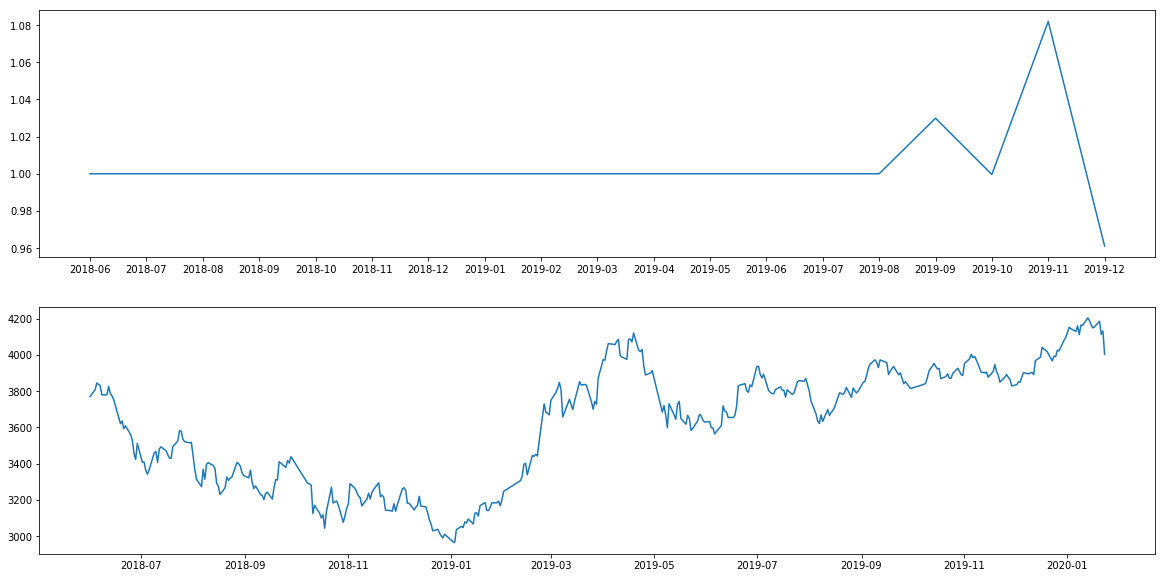

In [63]:
sp_cumprod = strategy_profit['cumprod_profit']
p_hs300 = price.loc[test_start_date:test_end_date]['close']
#p_hs300 = get_price(select_index,start_date=test_start_date,end_date=test_end_date,fields=['close'])
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)
ax0.plot(sp_cumprod)
ax1.plot(p_hs300)
plt.show()

In [64]:
strategy_profit

,signal,profit,selct_profit,cumprod_profit,cumsum_profit
2018-06,0,0.000000,0.000000,1.000000,0.000000
2018-07,0,0.000000,0.000000,1.000000,0.000000
2018-08,0,0.000000,0.000000,1.000000,0.000000
2018-09,0,0.000000,0.000000,1.000000,0.000000
2018-10,0,0.000000,0.000000,1.000000,0.000000
2018-11,0,0.000000,0.000000,1.000000,0.000000
2018-12,0,0.000000,0.000000,1.000000,0.000000
2019-01,0,0.000000,0.000000,1.000000,0.000000
2019-02,0,0.000000,0.000000,1.000000,0.000000
2019-03,0,0.000000,0.000000,1.000000,0.000000


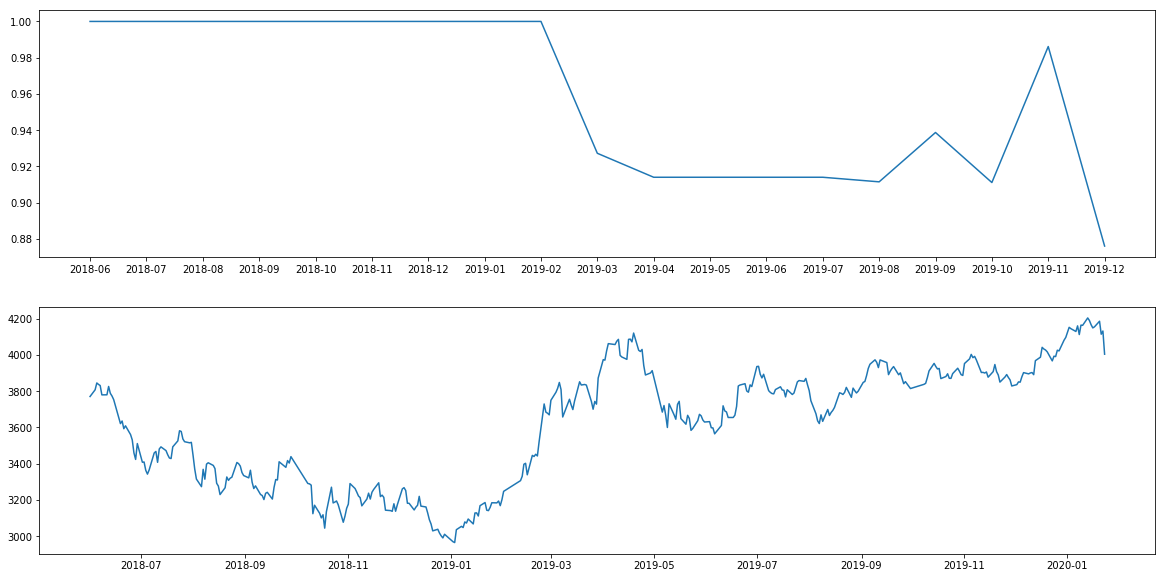

In [41]:
sp_cumprod = strategy_profit['cumprod_profit']
p_hs300 = price.loc[test_start_date:test_end_date]['close']
#p_hs300 = get_price(select_index,start_date=test_start_date,end_date=test_end_date,fields=['close'])
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)
ax0.plot(sp_cumprod)
ax1.plot(p_hs300)
plt.show()